# LJ Tutorial 

Environment setup
```
git clone git@github.com:jennyfothergill/msibi.git
cd msibi
conda env create -f environment.yml
conda activate msibi
pip install -e .
```

In [1]:
import itertools

import freud
import gsd
import gsd.hoomd
import hoomd
import hoomd.md
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

from msibi import MSIBI, State, Pair, mie

Remove old runs: only the rdf targets, run_template scripts, and the start.hoomdxml remain.

In [4]:
%%bash
rm -rf state*/_* rdfs/pair* potentials/* f_fits.log state*/log.txt state*/err.txt state*/run.py state*/query.dcd

Create the trajectories at the three statepoints... takes about 40 minutes on 2.2 GHz Intel Core i7.

In [5]:
kTs = [0.5, 1.5, 2.0]
n = 12
n_particles = n**3

In [4]:
# This cell takes 40 minutes. Don't uncomment and rerun it unless you have a good reason.

#for i,kT in enumerate(kTs):
#    hoomd.context.initialize("")
#    system = hoomd.init.create_lattice(
#        unitcell = (hoomd.lattice.sc(a=1.58, type_name="A")), 
#        n = n,
#    )
#    
#    nl = hoomd.md.nlist.cell()
#    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
#    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
#    hoomd.md.integrate.mode_standard(dt=0.001)
#    _all = hoomd.group.all()
#    nvt = hoomd.md.integrate.nvt(group=_all, kT=kT, tau=1)
#    nvt.randomize_velocities(seed=23)
#    hoomd.analyze.log(
#        filename=f'state{i}/LJ_kT{kT}.log',
#        quantities=["time", "temperature", "potential_energy"],
#        period=100,
#        overwrite=True
#    )
#    hoomd.dump.gsd(f'state{i}/trajectory{kT}.gsd', period=5e3, group=_all, overwrite=True)
#    hoomd.run(1e6)

Check that the system is equilibrated.

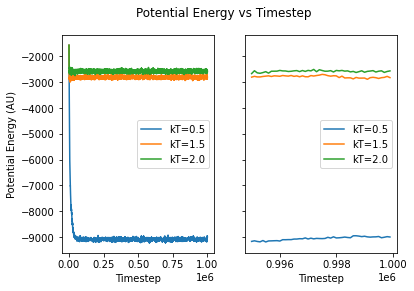

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle("Potential Energy vs Timestep")
for i, kT in enumerate(kTs):   
    log = np.loadtxt(f'state{i}/LJ_kT{kT}.log', skiprows=1)
    ax1.plot(log[:,0],log[:,3], label=f"kT={kT}")
    ax2.plot(log[-50:,0],log[-50:,3], label=f"kT={kT}")
    ax1.set_xlabel("Timestep")
    ax2.set_xlabel("Timestep")
    ax1.set_ylabel("Potential Energy (AU)")
    ax1.legend()
    ax2.legend()

Last 50 frames look equilibrated (TODO autocorrelation?) so we'll calculate the RDF of those.

NOTE: the next couple cells get very silly-- I got it in my head that the rdfs between freud and mdtraj were different and that was maybe what was causing my issue, so I felt the need to check that they were the same. Well, they _are_ the same and I still don't know what my issue is.

The error I am getting is 

```RuntimeError: Undefined values in tail of potential.This probably means you need better sampling at this state point.```

does this mean I need more points in my rdf or I need a smaller timestep in my md run or what???

In [113]:
class Traj(object):
    def __init__(self, gsdfile, start):
        self._have_unitcell = True
        with gsd.hoomd.open(gsdfile) as t:
            self.xyz = np.stack([frame.particles.position for frame in t[start:]])
            self.unitcell_vectors = t[start:]
            
    @property
    def xyz(self):
        return self._xyz
    
    @xyz.setter
    def xyz(self, xyz):
        self._xyz = xyz
        self.n_atoms = xyz.shape[1]
        
    @property
    def unitcell_vectors(self):
        return self._unitcell_vectors
    
    @unitcell_vectors.setter
    def unitcell_vectors(self, traj):
        try:
            self._unitcell_vectors = np.stack(
                [box_to_matrix(f.configuration.box) for f in traj]
            )
            self.unitcell_angles = np.ones(3)*90
            self.unitcell_volumes = np.array([box_to_volume(f.configuration.box) for f in traj])
        except AttributeError:
            self._have_unitcell = False

In [110]:
def box_to_matrix(box):
    lx,ly,lz,xy,xz,yz = box
    return np.array(
        [[lx, xy*ly, xz*lz],
         [ 0,    ly, yz*lz],
         [ 0,     0,    lz]]
    )

def box_to_volume(box):
    lx,ly,lz,xy,xz,yz = box
    x = np.array(
        [[lx, xy*ly, xz*lz],
         [ 0,    ly, yz*lz],
         [ 0,     0,    lz]]
    )
    return np.product(np.sqrt(np.sum(x**2, axis=0)))

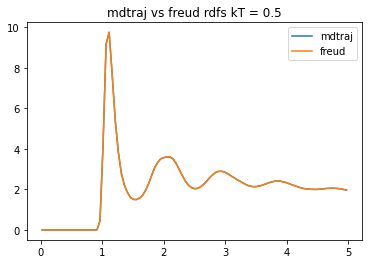

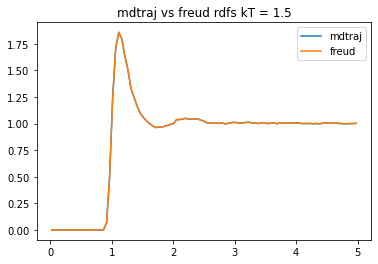

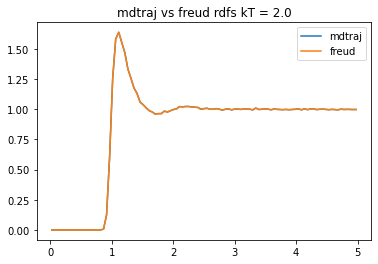

In [121]:
for i,kT in enumerate(kTs):
    gsdfile = f'state{i}/trajectory{kT}.gsd'
    traj = Traj(gsdfile,-50)
    rdf = md.compute_rdf(traj, indices, r_range=(0.0,5.0), n_bins=101)
    plt.title(f"mdtraj vs freud rdfs kT = {kT}")
    plt.plot(rdf[0],rdf[1], label="mdtraj")
    with gsd.hoomd.open(gsdfile) as t:
        rdf = freud.density.RDF(bins=101, r_max=5)
        for snap in t[-50:]:
            rdf.compute(system=snap, reset=False)
        data = np.stack((rdf.bin_centers, rdf.rdf)).T
        np.savetxt(f"rdfs/rdftarget{i}", data)
        plt.plot(rdf.bin_centers, rdf.rdf, label="freud")
        plt.legend()
        plt.show()

Set up global parameters:

- rdf_cutoff specifies how far out to calculate the rdf
- pot_cutoff specifies where to cut off the IBI calculation of the potential. The tail of the potential function (by default the last 5 points will be smoothed to zero using the [XPLOR smoothing function](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.pair). Small r values of the potential are also corrected using a linear correction by default. 
- smooth_rdfs if True, applies a Savitzky-Golay filter to the rdf array

TODO: this notebook should 
- show lj run √, 
- calculation of rdf √, 
- and prove that starting with the boltzmann inverse can iterate closer to "true" potential

- currently using mdtraj to load trajectory (dcd) and compute rdf--switch to freud and gsd?

- switch dcd to gsd?

- also why not show the smoothing etc?

In [6]:
rdf_cutoff = 5.0
opt = MSIBI(
    rdf_cutoff=rdf_cutoff, n_rdf_points=101, pot_cutoff=3.0, smooth_rdfs=True
)

Specify states

In [7]:
state0 = State(
    kT=0.5, 
    state_dir='./state0', 
    traj_file='trajectory0.5.gsd',
    name='state0', 
    backup_trajectory=True
)
state1 = State(
    kT=1.5, 
    state_dir='./state1', 
    traj_file='trajectory1.5.gsd',
    name='state1',
    backup_trajectory=True
)
state2 = State(
    kT=2.0, 
    state_dir='./state2', 
    traj_file='trajectory2.0.gsd',
    name='state2', 
    backup_trajectory=True
)
states = [state0, state1, state2]

Specify pairs

In [8]:
# all-all for n_particles atoms
# TODO use freud neighborlist?
# TODO write some logic to automate indices generation
indices = list(itertools.combinations(range(n_particles), 2))  

# 1-D array of potential values.
#TODO shouldn't this be boltzmann inverse?
initial_guess = mie(opt.pot_r, 1.0, 1.0)  # np array shape (61,)
rdf_targets = [
    np.loadtxt(f"rdfs/rdftarget{i}") for i in range(3)
]

pair0 = Pair('A', 'A', initial_guess)
alphas = [1.0, 1.0, 1.0]

/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)
/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: invalid value encountered in subtract
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)


Add targets to pair

In [9]:
for state, target, alpha in zip(states, rdf_targets, alphas):
    pair0.add_state(state, target, alpha, indices)
pairs = [pair0]  # optimize() expects a list of pairs

Implement MSIBI algorithm

TODO next
- find where it is still using hoomdxml even though new top file is supplied??√
- verbose mode so I can watch what's happening

```
(optimize.py) MSIBI.optimize() 
-> MSIBI._update_potentials()
-> (pair.py) Pair.update_potential()
-> head_correction --> RuntimeError
```


In [10]:
opt.optimize(states, pairs, n_iterations=5, engine='hoomd', verbose=True)

Using HOOMD version 2.
-------- Iteration 0 --------
state0 traj before run_query <class 'NoneType'>
Launching 4 CPU threads...
    Running state state0 on CPU
    Running state state2 on CPU
    Launched HOOMD in ./state0    Launched HOOMD in ./state2

    Running state state1 on CPU
    Launched HOOMD in ./state1
    Finished in ./state1.
    Finished in ./state2.
    Finished in ./state0.
state0 traj after run_query <class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'n_frames'

optimize should be calling `run_query_simulations` in workers.py before `self._update_potentials`
which should load `self.traj` but it seems like it's not...

checking err.txt is very useful!:
```
  File "run.py", line 11, in <module>
    with gsd.hoomd.open("./state0/trajectory0.5.gsd") as t:
NameError: name 'gsd' is not defined
```

new error:
```
with gsd.hoomd.open("./state0/trajectory0.5.gsd") as t:
  File "/Users/jenny/miniconda3/envs/msibi/lib/python3.8/site-packages/gsd/hoomd.py", line 1037, in open
    gsdfileobj = fl.open(name=str(name),
  File "gsd/fl.pyx", line 237, in gsd.fl.open
  File "gsd/fl.pyx", line 358, in gsd.fl.GSDFile.__init__
  File "gsd/fl.pyx", line 44, in gsd.fl.__raise_on_error
OSError: [Errno 9] Bad file descriptor: './state0/trajectory0.5.gsd'
```

vvv just noticed this in workers.py vvv
```
proc = Popen(
    cmds, cwd=state.state_dir, stdout=log, stderr=err,
    universal_newlines=True
    ) 
```
cwd is set to the state dir... so it's trying to find the dir in the dir ;P which allows me to replicate the error with this:

```
with gsd.hoomd.open("./state0/state0/trajectory0.5.gsd") as t:
    print(type(t))
```
`==> OSError: [Errno 9] Bad file descriptor: './state0/state0/trajectory0.5.gsd'`

In [10]:
with gsd.hoomd.open("./state0/state0/trajectory0.5.gsd") as t:
    print(type(t))

OSError: [Errno 9] Bad file descriptor: './state0/state0/trajectory0.5.gsd'

Plot results

In [2]:
import matplotlib.pyplot as plt

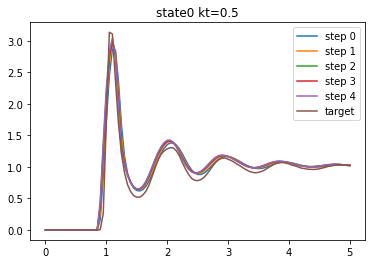

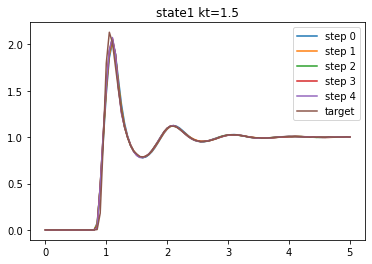

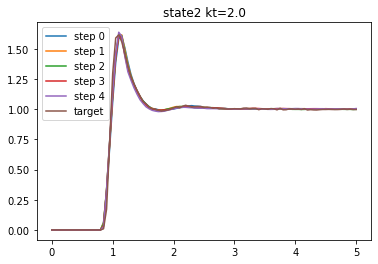

In [45]:
for state in states:
    plt.title(f'{state.name} kt={state.kT}')
    
    for step in range(0,opt.n_iterations):
        try:
            step_rdf = np.loadtxt(f'rdfs/pair_1-1-state_{state.name}-step{step}.txt')
            plt.plot(step_rdf[:,0],step_rdf[:,1], label=f'step {step}')
        except OSError:
            target = np.loadtxt(f'rdfs/rdf.target{state.name.strip("state")}.t1t1.txt')
            plt.plot(target[:,0], target[:,1], label='target')
            plt.legend()
            plt.show()
            break

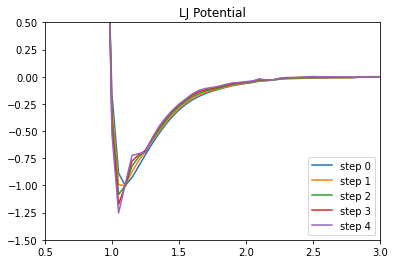

In [60]:
for step in range(0,opt.n_iterations):
    plt.ylim([-1.5,0.5])
    plt.xlim([0.5,3])
    plt.title("LJ Potential")
    try:
        step_pot = np.loadtxt(f'potentials/step{step}.pot.1-1.txt')
        plt.plot(step_pot[:,0],step_pot[:,1], label=f'step {step}')
    except OSError:
        plt.legend()
        plt.show()
        break

what potential was used to generate the targets?

In [65]:
from MDAnalysis.lib.formats.libdcd import DCDFile

In [70]:
with DCDFile('state0/query.dcd') as f:
    for frame in f:
        pass
print(frame.xyz)

[[-4.9447665  4.982726   2.500051 ]
 [-3.6839077 -4.326487   2.6648674]
 [ 3.8916466 -1.7114909 -4.8555593]
 ...
 [-0.8723145  2.4930065  2.9952328]
 [ 2.6854112 -1.4036062 -1.6191419]
 [-3.33116    3.018204   2.0835867]]
